In [3]:
import time

import numpy as np
import einops.einops as einops
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import wandb
import safetensors.torch as st

import datasets.core
import datasets.eurosat

torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
# see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228

Using cuda
There are 16200 training samples
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=False)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[0.0, 0.0], shear=[-0.2, 0.2])
    RandomAffine(degrees=[0.0, 0.0], scale=(1.0, 1.2))
    datasets.core.ClampTransform(min=0.0, max=2750.0)
)


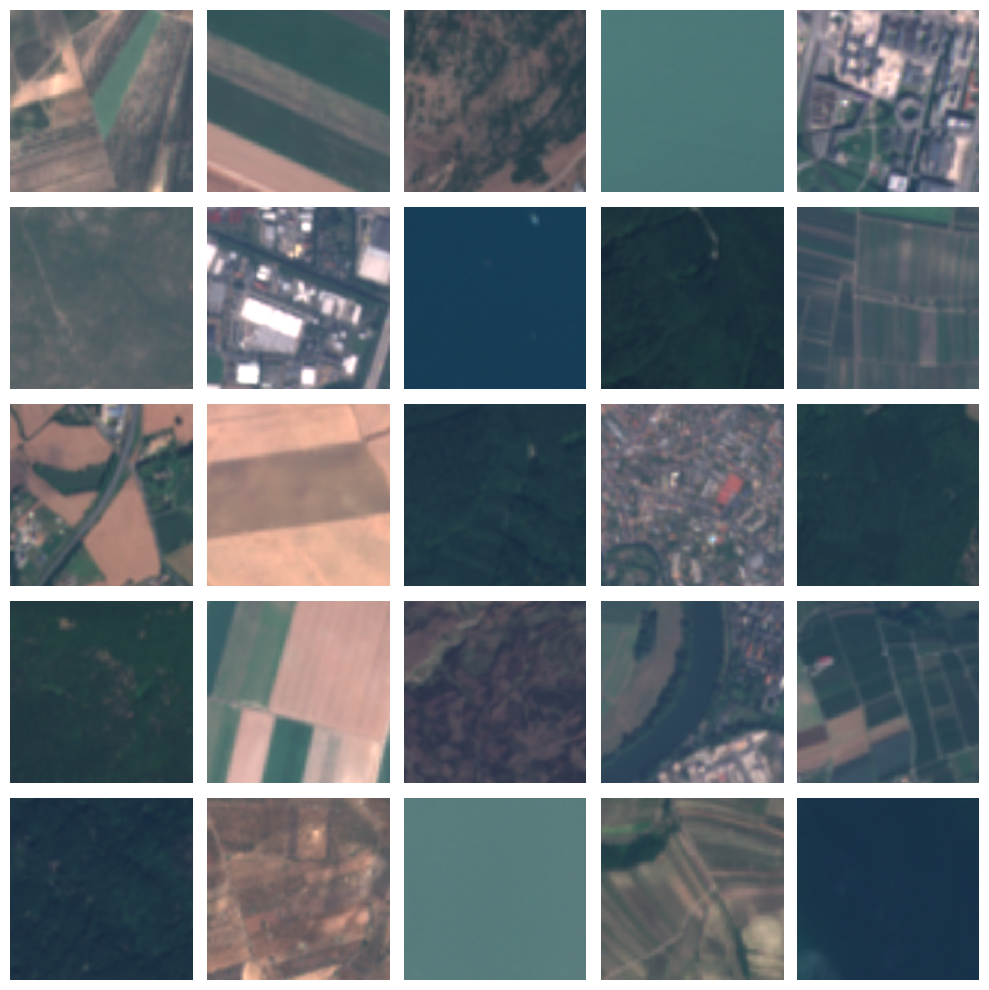

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

base_transforms = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),  # Authors rescale images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, shear=0.2),  # Shear with range 0.2
    transforms.RandomAffine(0, scale=(1., 1.2)),  # Zoom in with range 0.2
    datasets.core.ClampTransform(input_min=0., input_max=2750.)  # Authors clamp from 0.-2750 but torchgeo uses 3000
])
wrapped_transforms = datasets.core.tensor_dict_transform_wrapper(base_transforms)

test_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=False),
    datasets.core.ClampTransform(input_min=0., input_max=2750.)
])
wrapped_rescale_clamp_transform = datasets.core.tensor_dict_transform_wrapper(test_transform)

eurosat_train_ds = datasets.eurosat.get_dataset("train", transforms=wrapped_transforms)
eurosat_test_ds = datasets.eurosat.get_dataset("test", transforms=wrapped_rescale_clamp_transform)
# eurosat_test_ds = datasets.eurosat.get_dataset("test", transforms=resize_transform)
print(f"There are {len(eurosat_train_ds)} training samples")  # and {len(eurosat_test_ds)} test samples.")
print("Image dimensions and label:", eurosat_train_ds[0]["image"].size(), eurosat_train_ds[0]["label"])

print(base_transforms)

# Display 25 random images from the dataset without border
np.random.seed(42)
random_indices = np.random.choice(len(eurosat_train_ds), size=25, replace=False)
plt.figure(figsize=(10, 10), tight_layout=True)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.imshow(einops.rearrange(eurosat_train_ds[idx]["image"], "c h w -> h w c"))
    plt.axis("off")

## Basic CNN

In [5]:
class BaseCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # channels numbers for each layer are not specified by the authors
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # 3, 224, 224 -> 32, 224, 224
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 32, 224, 224 -> 32, 111, 111
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # 32, 111, 111  -> 64, 111, 111
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 64, 111, 111 -> 64, 54, 54
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # 64, 54, 54 -> 128, 54, 54
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=2), # 128, 54, 54 -> 128, 26, 26
        )
        self.fc = nn.Linear(128 * 26 * 26, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = einops.rearrange(out, 'b c h w -> b (c h w)')
        out = self.fc(out)
        return out

In [6]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# num_workers=0 is used to avoid a bug in the DataLoader when trying to pickle functions on windows
# see https://discuss.pytorch.org/t/cant-pickle-local-object-dataloader-init-locals-lambda/31857/31
train_dataloader = torch.utils.data.DataLoader(eurosat_train_ds, batch_size=16, num_workers=0, shuffle=True)
testing_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=32, num_workers=0, shuffle=True)
test_iterator = iter(cycle(testing_dataloader))

In [7]:
model = BaseCNN().to(device)
criterion = nn.CrossEntropyLoss()

learning_rate = 1e-3
decay = 1e-6
momentum=0.9
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=decay, momentum=momentum, nesterov=True)

In [8]:
from pathlib import Path
import json

env_file = Path.cwd() / "env.json"
env_settings = json.load(env_file.open("r"))
wandb_api_key = env_settings["wandb_api_key"]

In [9]:
# !wandb login $wandb_api_key

In [10]:
# todo: reload from state to resume training
num_epochs = 120

wandb.init(
    project="basic_eurosat_classification_lit_replication",
    name="SundayFullRun",
    notes="First attempted full run with weight saving and only one CPU thread.",
    config={
        "transforms": repr(base_transforms),
        "model_architecture": repr(model),
        "criterion": criterion.__class__.__name__,
        "optimiser_info": {
            "name": optimiser.__class__.__name__,
            "learning_rate": learning_rate,
            "decay": decay,
            "momentum": momentum
        },
        "dataset": "EuroSAT",
        "epochs": num_epochs,
        "start_time": time.asctime()
    }
)

training_loss_arr = np.zeros(0)
training_acc_arr = np.zeros(0)

for epoch in range(num_epochs):
    print(f"Epoch {epoch:03}")
    for i, data in enumerate(train_dataloader):
        model.train()
        images = data["image"].to(device)
        labels: torch.Tensor = data["label"].to(device)
        
        predictions = model(images)
        
        loss = criterion(predictions, labels)
        training_loss_arr = np.append(training_loss_arr, loss.item())
        
        accuracy = (predictions.argmax(dim=1) == labels).float().mean().item()
        training_acc_arr = np.append(training_acc_arr, accuracy)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        

        if i % 200 == 0:
            model.eval()
            with torch.no_grad():
                print(f"Epoch {epoch:03} - Batch num {i:05}")
                testing_loss_arr = np.zeros(0)
                testing_acc_arr = np.zeros(0)
                for _ in range(20):  # iterate over 20 batches
                    test_data = next(test_iterator)
                    test_images = test_data["image"].to(device)
                    test_labels: torch.Tensor = test_data["label"].to(device)
                    
                    test_predictions = model(test_images)
                    
                    test_loss = criterion(test_predictions, test_labels)
                    testing_loss_arr = np.append(testing_loss_arr, test_loss.item())
                    
                    test_accuracy = (test_predictions.argmax(dim=1) == test_labels).float().mean().item()
                    testing_acc_arr = np.append(testing_acc_arr, test_accuracy)
    
                wandb.log({
                    "overall_step": epoch * len(train_dataloader) + i,
                    "training/loss": training_loss_arr.mean(),
                    "training/accuracy": training_acc_arr.mean(),
                    "testing/loss": testing_loss_arr.mean(),
                    "testing/accuracy": testing_acc_arr.mean()
                })
                print(f"Training loss: {training_loss_arr.mean():.2f}, Training accuracy: {training_acc_arr.mean():.2f}")
                print(f"Testing loss: {testing_loss_arr.mean():.2f}, Testing accuracy: {testing_acc_arr.mean():.2f}")
                
                training_loss_arr = np.zeros(0)
                training_acc_arr = np.zeros(0)
    
    if epoch != 0 and epoch % 20 == 0:  
        st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_{epoch:03}.safetensors", metadata={"epoch": str(epoch)})
        print(f"Model saved at epoch {epoch:03}.")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tametnt (tametnt-durham-university). Use `wandb login --relogin` to force relogin


Epoch 000
Epoch 000 - Batch num 00000
Training loss: 2.30, Training accuracy: 0.12
Testing loss: 2.30, Testing accuracy: 0.09
Epoch 000 - Batch num 00200
Training loss: 1.95, Training accuracy: 0.24
Testing loss: 1.79, Testing accuracy: 0.29
Epoch 000 - Batch num 00400
Training loss: 1.59, Training accuracy: 0.38
Testing loss: 1.54, Testing accuracy: 0.40
Epoch 000 - Batch num 00600
Training loss: 1.48, Training accuracy: 0.46
Testing loss: 1.34, Testing accuracy: 0.53
Epoch 000 - Batch num 00800
Training loss: 1.36, Training accuracy: 0.50
Testing loss: 1.50, Testing accuracy: 0.40
Epoch 000 - Batch num 01000
Training loss: 1.25, Training accuracy: 0.55
Testing loss: 1.52, Testing accuracy: 0.43
Epoch 001
Epoch 001 - Batch num 00000
Training loss: 1.44, Training accuracy: 0.48
Testing loss: 1.16, Testing accuracy: 0.57
Epoch 001 - Batch num 00200
Training loss: 1.17, Training accuracy: 0.58
Testing loss: 1.15, Testing accuracy: 0.57
Epoch 001 - Batch num 00400
Training loss: 1.09, Tra

KeyboardInterrupt: 

In [11]:
wandb.finish()

overall_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
testing/accuracy,▃▁▃▄▅▆▆▇▇█▇▇▇▇▇██▇▇█▇▇███▇████▇█████████
testing/loss,█▄▃▃▃▄▂▃▂▂▂▁▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▂▁▂▁▁▁▁▂▁▂▁▂▂
training/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
training/loss,█▇▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
overall_step,36868
testing/accuracy,0.88594
testing/loss,0.41656
training/accuracy,0.95906
training/loss,0.11815


In [12]:
st.save_model(model, f"checkpoints/basic_cnn_eurosat_epoch_036.safetensors", metadata={"epoch": str(36)})

In [23]:
model.eval()

eval_set = datasets.eurosat.get_dataset("test", transforms=wrapped_rescale_clamp_transform)
eval_dataloader = torch.utils.data.DataLoader(eurosat_test_ds, batch_size=64, num_workers=0, shuffle=False)

with torch.no_grad():
    batch_accuracy = np.zeros(0)
    
    all_labels = np.zeros(0)
    all_predictions = np.zeros(0)
    
    for i, data in enumerate(eval_dataloader):
        print(f"Assessing batch {i:05}", end="\r")
        images = data["image"].to(device)
        labels = data["label"].to(device)
        
        outputs = model(images)
        predictions = outputs.argmax(dim=1, keepdim=True)

        all_labels = np.append(all_labels, labels.cpu().numpy())
        all_predictions = np.append(all_predictions, predictions.cpu().numpy())
        
        batch_accuracy = np.append(batch_accuracy, predictions.data.eq(labels.view_as(predictions)).float().mean().item())

    print(f"Accuracy of the model on the {len(all_labels)} test images: {batch_accuracy.mean():.2f}")

Accuracy of the model on the 5400 test images: 0.89


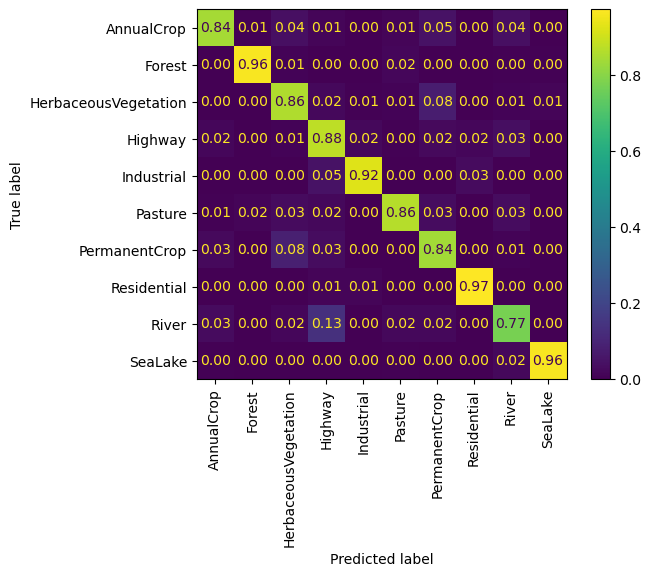

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(all_labels, all_predictions,
                                        normalize="true", values_format=".2f",
                                        display_labels=eurosat_test_ds.classes, xticks_rotation="vertical")

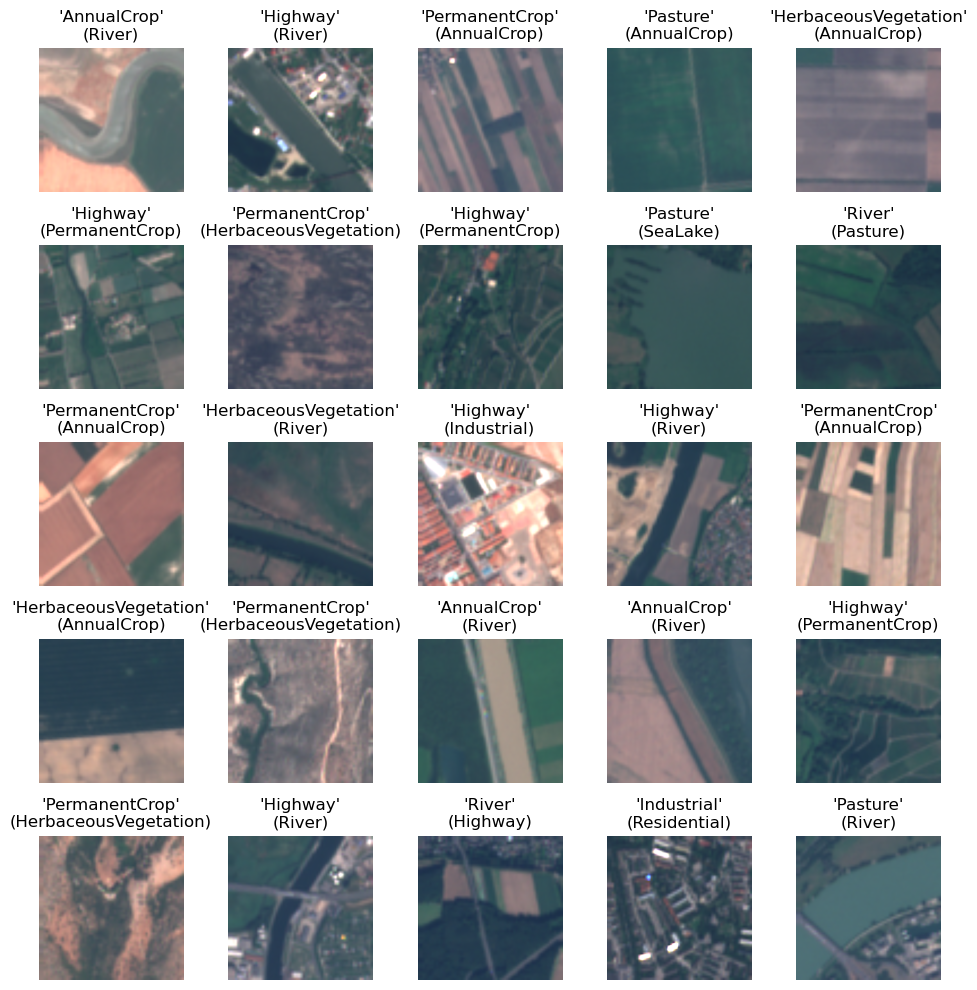

In [32]:
incorrect_idxs = np.where(all_labels != all_predictions)[0]

# Display 25 random images from the dataset without border
np.random.seed(69)
random_indices = np.random.choice(incorrect_idxs, size=25, replace=False)
plt.figure(figsize=(10, 10), tight_layout=True)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.title(f"'{eurosat_test_ds.classes[int(all_predictions[idx])]}'\n({eurosat_test_ds.classes[int(all_labels[idx])]})")
    plt.imshow(einops.rearrange(eurosat_test_ds[idx]["image"], "c h w -> h w c"))
    plt.axis("off")

In [33]:
eurosat_test_ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

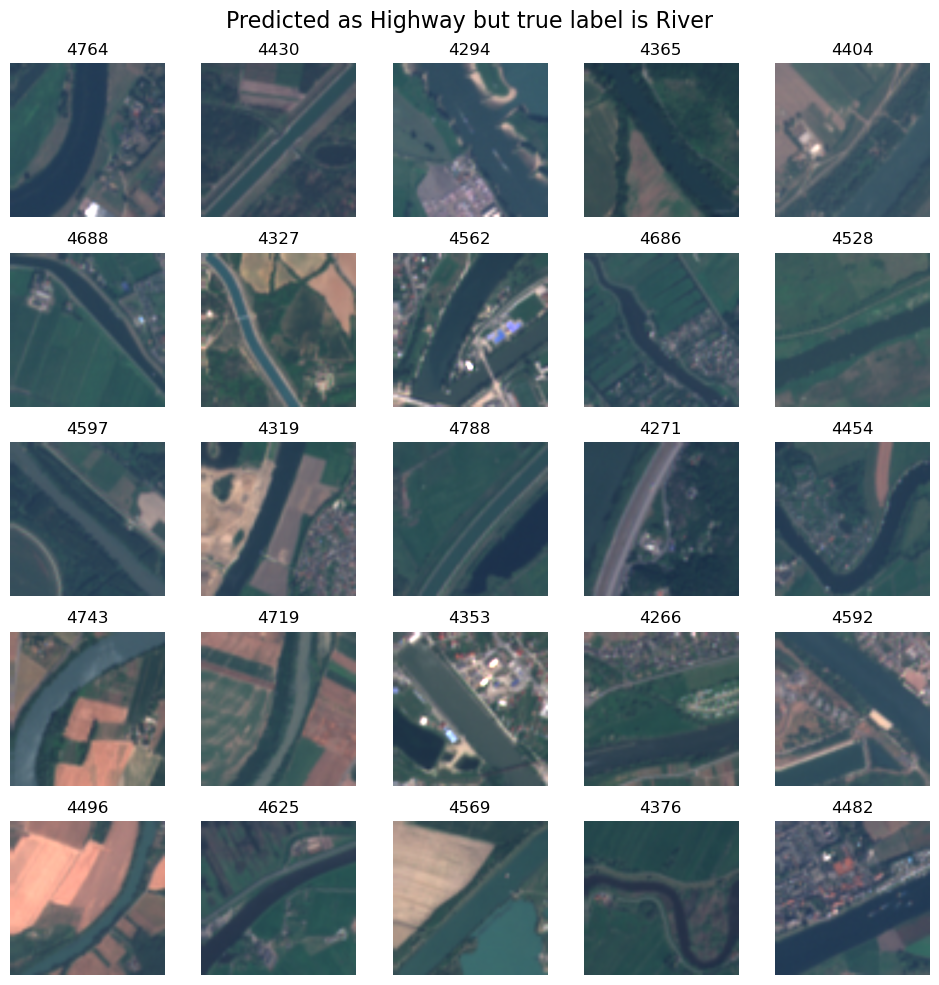

In [39]:
# get the indices where highway was predicted but true label was river
incorrect_idxs = np.where((all_predictions == 3.0) & (all_labels == 8.0))[0]

# Display 25 random images from the dataset without border
np.random.seed(69)
random_indices = np.random.choice(incorrect_idxs, size=25, replace=False)
fig = plt.figure(figsize=(10, 10), tight_layout=True)
fig.suptitle(f"Predicted as {eurosat_test_ds.classes[3]} but true label is {eurosat_test_ds.classes[8]}", fontsize=16)
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 5, i + 1)
    plt.title(f"{idx}")
    plt.imshow(einops.rearrange(eurosat_test_ds[idx]["image"], "c h w -> h w c"))
    plt.axis("off")

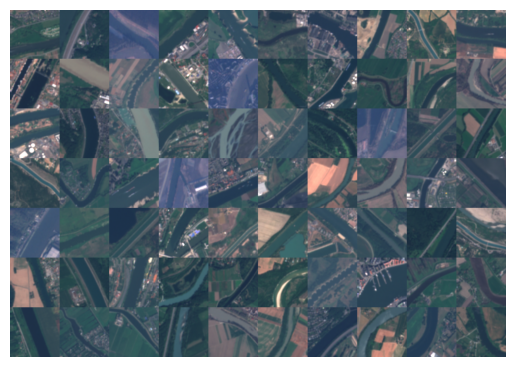

In [52]:
concat_images = torch.stack([eurosat_test_ds[idx]["image"] for idx in incorrect_idxs])
plt.axis("off")
plt.imshow(einops.rearrange(concat_images[:-1], "(rows cols) c h w -> (rows h) (cols w) c", rows=7, cols=10))